# Tomography


The goal of this notebook is doing some improvements and understand better tomography and the photon detection, in contrast with the notebook "Fitting r", which is for trying new things that I don't know how to do in Python.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import factorial
%matplotlib inline

from scipy import optimize
from scipy.optimize import minimize
import time

## Definition of the click probability


It is known that the detection probability of the detector is: $$R(N)=1-e^{-\eta N}\sum_{i=0}^m(1-p_i)\frac{(\eta N)^i}{i!}$$
Where $N$ (independent variable) is the avereged number of photons, $\eta$ the efficiency of the detector and $p_i$ the probability for detecting a certain number of photons

In [3]:
def Click(N, eta, p, G):
    """"
    Calculates de click probability for a given number of photons
    
    Parameters
    ----------
    N: array
        (Independent variable). Number of photons
    
    eta: float
        Efficiency of the detector
        
    p: array
        Each element of the array indicates the probability of measuring a
        detection of certain number of photons. First element for one photon
        detection, second element for two photons detection, ...
        
    G: int
        It indicates the number of elements in 'p' that will be considered.
    

    """
    summ = 0
    for i in range(0,G):
        summ = summ + (1-p[i]) * (eta*N)**i / factorial(i)
            
    R = 1 - np.exp(-eta*N)*summ
    return R

## Plot $R(N)$ vs N

In this section it is decided what values of $N$, $ \eta $ and {$p_i$} are used. For the moment only $p_0$, $p_1$ and $p_2$ are used. As $p_0$ corresponds to the dark counts and we want to consider them apart from this formula we fix the probability to zero, $p_0=0$

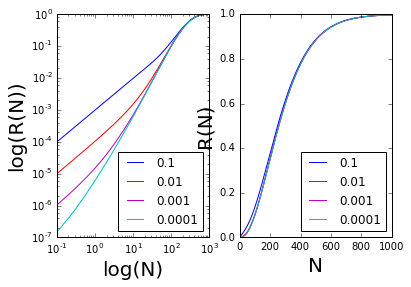

In [4]:
N   = np.linspace(0.1, 1000, 10000) #Number of photons (independet variable)
eta = 0.01 #Efficiency

plt.subplot(121)
plt.loglog(N, Click (N, eta, np.array([0.0 , 0.1, 0.1]), 3),'b')
plt.loglog(N, Click (N, eta, np.array([0.0 , 0.01, 0.1]), 3),'r')
plt.loglog(N, Click (N, eta, np.array([0.0 , 0.001, 0.1]), 3),'m')
plt.loglog(N, Click (N, eta, np.array([0.0 , 0.0001, 0.1]), 3),'c')

plt.xlabel('log(N)', fontsize=20)
plt.ylabel('log(R(N))', fontsize=20)
plt.legend([0.1, 0.01, 0.001, 0.0001], loc=0)

plt.subplot(122)
plt.plot(N, Click (N, eta, np.array([0.0 , 0.1, 0.1]), 3),'b')
plt.plot(N, Click (N, eta, np.array([0.0 , 0.01, 0.1]), 3),'r')
plt.plot(N, Click (N, eta, np.array([0.0 , 0.001, 0.1]), 3),'m')
plt.plot(N, Click (N, eta, np.array([0.0 , 0.0001, 0.1]), 3),'c')

plt.xlabel('N', fontsize=20)
plt.ylabel('R(N)', fontsize=20)
plt.legend([0.1, 0.01, 0.001, 0.0001], loc=0)


## What is the role of $p_0$ in the click probability?

After following the deduction of $R(N)$ we've realised that $p_0$ has the meaning for the probability of detecting 0 photons. In this section we'll study the implications of this fact.


Now we're going to define the same function but ignoring the term n=0. We'll omit this term in the summation and check if the results are still consistent.
We know that if we extract the contribution of $p_0$ from the summation this is the result:
$$R(N)=1-e^{-\eta N}(1-p_0)-e^{-\eta N}\sum_{i=1}^m(1-p_i)\frac{(\eta N)^i}{i!}=R'(N)-e^{-\eta N}(1-p_0)$$

As a consequence of this term there will always be a contribution from $p_0$ in our equation except when $p_0=1$. Let's see how this affect to the result.

In [5]:
def Click_p0(N, eta, p, G):
    """"
    Calculates de click probability for a given number of photons ignoring 
    the contribution of p0
    
    Parameters
    ----------
    N: array
        (Independent variable). Number of photons
    
    eta: float
        Efficiency of the detector
        
    p: array
        Each element of the array indicates the probability of measuring a
        detection of certain number of photons. First element for one photon
        detection, second element for two photons detection, ...
        
    G: int
        It indicates the number of elements in 'p' that will be considered.
    

    """
    summ = 0
    for i in range(1,G):
        summ = summ + (1-p[i]) * (eta*N)**i / factorial(i)
            
    R = 1 - np.exp(-eta*N)*summ
    return R

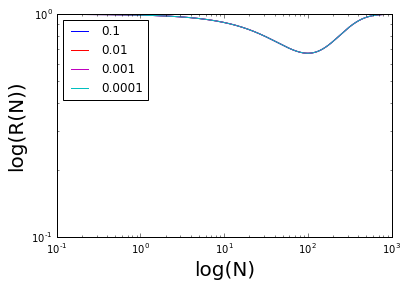

In [6]:
N   = np.linspace(0.1, 1000, 10000) #Number of photons (independet variable)
eta = 0.01 #Efficiency

plt.loglog(N, Click_p0 (N, eta, np.array([0.1, 0.1]), 2),'b')
plt.loglog(N, Click_p0 (N, eta, np.array([0.01, 0.1]), 2),'r')
plt.loglog(N, Click_p0 (N, eta, np.array([0.001, 0.1]), 2),'m')
plt.loglog(N, Click_p0 (N, eta, np.array([0.0001, 0.1]), 2),'c')

plt.xlabel('log(N)', fontsize=20)
plt.ylabel('log(R(N))', fontsize=20)
plt.legend([0.1, 0.01, 0.001, 0.0001], loc=0)


Comparing this graph with the one considering $p_0$ we realise that the contribution $e^{-\eta N}(1-p_0)$ plays an important role in the probability of detection.


As a consequence we have to think which solution is needed for the dark counts. The solution, and from this point, the procedure will be the next one:
Set $p_0=0$ and leave the exponential contribution and consider the dark counts in another variable.

$$R(N)=1-e^{-\eta N}\sum_{i=0,\space p_0=0}^m(1-p_i)\frac{(\eta N)^i}{i!}+R_{dark}$$

$$R(N)-R_{dark}=1-e^{-\eta N}\sum_{i=0,\space p_0=0}^m(1-p_i)\frac{(\eta N)^i}{i!}$$



## Minimization of  $\chi ²$
 

In this section a fit is done for calculating the values of our parameters $\eta$ and {$p_i$} which minimize the $\chi^2$ value.

In [ ]:
def ERR_fun(Arr1, Arr2):
    """
    TODO: writing descripting of the function 
    Chi-squared
    """
    return np.sum((Arr1-Arr2)**2 / (Arr2)**2)

def FUNC2MINIMIZE(Params):
    """
    TODO: writing descripting of the function 
    """
    Data_expected = Click(N, Params[0], Params[1:], Params.size-1)
    return ERR_fun(Data_simul, Data_expected)


For minimazing the data first we have to generate some sinthetic data, in the future these data will be our experimental points. 


In [8]:
N   = np.linspace(0.1, 1000, 100000) #Number of photons (independet variable)
eta = 0.01 #Efficiency
p   = np.array([0.0, 0.01, 0.1])
G   = p.size

# I create the synthetic data with the random noise   
R    = Click (N, eta, p, G)
freq = 2 * np.power(10, 7) #Repetition rate of the laser (s^(-1))
t    = 100 #Time integration (s)

#Data_simul = R + np.sqrt(R*(1-R)/(freq * t)) #with real noise
Data_simul = R  + np.random.rand(len(N))*0.001


min(R)

1.0040121565024762e-05

###### In the cell above I have a problem. If I insert the Data_simul without noise or with the real noise I get error in the fitting. Also I get the error if I make the random noise really small.

In [9]:
f = FUNC2MINIMIZE


bnds = ((0,1),) * (len(p)+1) #This boundaries for all my variables
x0 = np.array([0.01, 0.0, 0.02, 0.3]) #Initial guesses
x_opt = optimize.minimize(f, x0, bounds = bnds)
print(x_opt)



      fun: 89.13867596758746
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01376179,  0.0081755 , -0.00025864, -0.00024301])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 345
      nit: 52
   status: 0
  success: True
        x: array([ 0.00998171,  0.00065904,  0.00917123,  0.10610039])


We want to compare our experimental data with the simulation of this results using the fitted parameters.

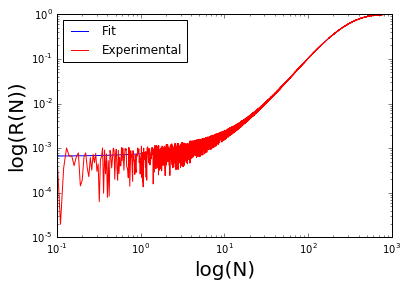

In [10]:
FIT = Click(N, x_opt.x[0], x_opt.x[1:], len(x_opt.x)-1)

plt.loglog(N, FIT, 'b')
plt.loglog(N, Data_simul, 'r')

plt.xlabel('log(N)', fontsize=20)
plt.ylabel('log(R(N))', fontsize=20)
plt.legend(['Fit', 'Experimental'], loc=0)

## LET'S DO THE SAME WITH A LOOP

Now I will make a loop for minimizating for several number of parameters and after look for the one which has the minimum $\chi^2$ 

In [60]:
N   = np.linspace(0.1, 1000, 100000) #Number of photons (independet variable)
eta = 0.01 #Efficiency
p   = np.arange(11)/10
G   = p.size

# I create the synthetic data with the random noise   
R    = Click (N, eta, p, G)
freq = 2 * np.power(10, 7) #Repetition rate of the laser (s)
t    = 100 #Time integration (s)

#Data_simul = R + np.sqrt(R*(1-R)/(freq * t))
Data_simul = R  + np.random.rand(len(N))*0.001

In [69]:
f = FUNC2MINIMIZE

m0 = 4 #Number of parameters of the first fit (including eta)
m = 12 #Number of parameters of the last fit (including eta)
# I think that we won't go further than m=6

x0_values = np.array([0.01, 0, 0.1, 0.2])
min_chi   = np.empty(m-m0+1)


for i in range(m0, m+1):
    bnds = ((0,1),) * (i) #This boundaries for all my variables
    x01 = x0_values[0:i-1]
    x0 = np.append(x01, x01[-1] + 0.1)
    print('Parameters iterating:', i)
    tic = time.clock()
    x_opt = optimize.minimize(f, x0, bounds = bnds)
    toc = time.clock()
    print('Iteration time:', toc-tic)
    x0_values = x_opt.x
    min_chi[i-m0] = x_opt.fun 
    print('Parameters', x0_values)


Parameters iterating: 4
Iteration time: 1.8932859999999891
Parameters [ 0.00462729  0.0005134   0.25322497  0.35402311]
Parameters iterating: 5
Iteration time: 5.009942000000137
Parameters [ 0.00608071  0.00063647  0.17700196  0.43210555  0.31366396]
Parameters iterating: 6
Iteration time: 8.277928999999858
Parameters [ 0.00704897  0.0006102   0.1557618   0.32676949  0.48526896  0.48527599]
Parameters iterating: 7
Iteration time: 22.321840000000066
Parameters [ 0.00802302  0.00060014  0.1378648   0.27946428  0.41967169  0.5694071
  0.57325822]
Parameters iterating: 8
Iteration time: 30.10703599999988
Parameters [  9.01524095e-03   6.10035541e-04   1.21725916e-01   2.61038559e-01
   3.24686976e-01   5.59820927e-01   6.16252347e-01   6.11777425e-01]
Parameters iterating: 9


/home/jaime/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/home/jaime/anaconda3/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Iteration time: 77.25381000000016
Parameters [  9.73769748e-03   6.08243552e-04   1.12934292e-01   2.37501362e-01
   3.24820144e-01   4.63141906e-01   5.91847407e-01   6.92147904e-01
   7.16331369e-01]
Parameters iterating: 10
Iteration time: 45.84408099999973
Parameters [  1.06893597e-02   6.09688621e-04   1.02822483e-01   2.16088111e-01
   3.01527144e-01   4.08466566e-01   5.33795646e-01   6.58647821e-01
   7.14200173e-01   7.38189036e-01]
Parameters iterating: 11
Iteration time: 79.87509100000034
Parameters [  1.13905379e-02   6.03092723e-04   9.70868563e-02   1.96674785e-01
   3.00534399e-01   3.78310962e-01   4.69425363e-01   6.15182115e-01
   7.16930818e-01   7.72982790e-01   7.76444463e-01]
Parameters iterating: 12
Iteration time: 108.11792299999979
Parameters [  1.22009757e-02   6.07381672e-04   9.03260191e-02   1.87158429e-01
   2.67149520e-01   3.73709987e-01   4.36035756e-01   5.54312114e-01
   6.61507824e-01   7.48979816e-01   7.89662318e-01   8.18070124e-01]


(1, 13)

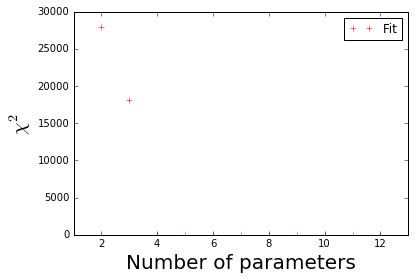

In [62]:
plt.plot(np.arange(m0,m+1), min_chi, 'r+')


plt.xlabel('Number of parameters', fontsize=20)
plt.ylabel('$\chi^2$', fontsize=20)
plt.legend(['Fit'], loc=0)

plt.xlim([m0-1, m+1])

In [63]:
min(min_chi) 
#Also know for which number of parameters is this

11.828962882747033

In [68]:
print(p)
print(x_opt.x)

[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
  0.66666667  0.77777778  0.88888889  1.        ]
[  1.16960165e-02   6.13809767e-04   9.36154341e-02   2.02998673e-01
   2.46054940e-01   4.38930944e-01   4.57243242e-01   5.25370705e-01
   6.81194660e-01   8.09331015e-01   8.66430097e-01   8.42764733e-01]


In [ ]:
FIT = Click(N, x_opt.x[0], x_opt.x[1:], len(x_opt.x)-1)

plt.loglog(N, FIT, 'b')
plt.loglog(N, Data_simul, 'r')

plt.xlabel('log(N)', fontsize=20)
plt.ylabel('log(R(N))', fontsize=20)
plt.legend(['Fit', 'Experimental'], loc=0)